In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isnan
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

## Data preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
X_revenue = []
X_income = []
train = {}
for company in os.listdir('/content/drive/MyDrive/oil_gas_train'):
    if company[:-5] != 'CRBO' and company[:-5] != '╨Ъ╨╜╨╕╨│╨░8':
        df = pd.read_excel(f'/content/drive/MyDrive/oil_gas_train/{company}')
        revenue = list(df.iloc[28])[9:]
        income = list(df.iloc[42])[9:]
        train[company[:-5]] = [revenue, income]
        X_revenue.append(revenue)
        X_income.append(income)

In [4]:
test = {}
for company in os.listdir('/content/drive/MyDrive/oil_gas_train_test'):
    if company[:-5] != 'CRBO' and company[:-5] != '╨Ъ╨╜╨╕╨│╨░8':
        df = pd.read_excel(f'/content/drive/MyDrive/oil_gas_train_test/{company}')
        revenue = list(df.iloc[28])[-4:]
        income = list(df.iloc[42])[-4:]
        test[company[:-5]] = [revenue, income]

In [5]:
X_revenue = pd.DataFrame(X_revenue).drop(0)
X_income = pd.DataFrame(X_income).drop(0)

## Baseline model

We will forecast income and revenue for AMPY company, using Gradient Boosting as a baseline model. We will use all the companies' revenues as a train dataset, except last period, it will be a target. After we get a fitted model, we use it  on original AMPY data and get predict. Later we will use this predict to get another 3 predictions by dropping oldest period and adding latest prediction to the data. 

In [6]:
def baseline_prediction(X, target):
    predictions = target
    y = X[37]
    X = X.drop(columns=[37])
    model = GradientBoostingRegressor()
    model.fit(X, y)
    for i in range(4):
        pred = model.predict(np.array(predictions[-37:]).reshape(1, -1))
        predictions.append(pred[0])
    return predictions

In [7]:
revenue_with_predictions = baseline_prediction(X_revenue, train['AMPY'][0])

In [8]:
income_with_predictions = baseline_prediction(X_income, train['AMPY'][1])

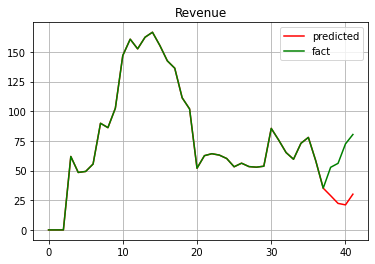

In [9]:
fig, ax = plt.subplots()

ax.plot(revenue_with_predictions, label = 'predicted', color='red')
ax.plot(revenue_with_predictions[:-4] + test['AMPY'][0], label = 'fact', color='green')

ax.legend()
ax.grid()
plt.title('Revenue')
plt.show()

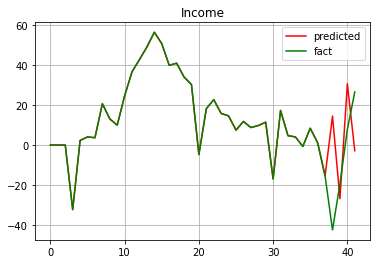

In [10]:
fig, ax = plt.subplots()

ax.plot(income_with_predictions, label = 'predicted', color='red')
ax.plot(income_with_predictions[:-4] + test['AMPY'][1], label = 'fact', color='green')

ax.legend()
ax.grid()
plt.title('Income')
plt.show()

In [11]:
x = test['AMPY']
print(f'mean squared error revenue: {mean_squared_error(x[0], revenue_with_predictions[-4:])}')

mean squared error revenue: 1719.4899213042606


In [12]:
print(f'mean squared error income: {mean_squared_error(x[1], income_with_predictions[-4:])}')

mean squared error income: 1171.0837974724386


## AutoML

Here we are forecasting revenue and income using [FEDOT](https://github.com/aimclub/FEDOT) AutoML framework.

In [18]:
import logging

from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
from fedot.core.utils import fedot_project_root

logging.raiseExceptions = False

In [29]:
def run_ts_forecasting_example(dataset: list, horizon: int = 4, validation_blocks=2, timeout: float = None,
                               visualization=False):
    time_series = pd.DataFrame(data={'idx': list(range(len(dataset))), 
                                     'value': dataset})

    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=horizon))

    idx = time_series['idx'].values
    time_series = time_series['value'].values
    train_input = InputData(idx=idx,
                            features=time_series,
                            target=time_series,
                            task=task,
                            data_type=DataTypesEnum.ts)
    train_data, test_data = train_test_data_setup(train_input, 
                                          validation_blocks=validation_blocks)

    # init model for the time series forecasting
    model = Fedot(problem='ts_forecasting',
                  task_params=task.task_params,
                  timeout=timeout,
                  n_jobs=1,
                  cv_folds=2, validation_blocks=validation_blocks,
                  preset='fast_train')

    # run AutoML model design in the same way
    pipeline = model.fit(train_data)

    # use model to obtain two-step in-sample forecast
    in_sample_forecast = model.predict(test_data)
    print('Metrics for two-step in-sample forecast: ',
          model.get_metrics(metric_names=['rmse', 'mae', 'mape']))

    # plot forecasting result
    if visualization:
        pipeline.show()
        model.plot_prediction()

    # use model to obtain one-step forecast
    train_data, test_data = train_test_data_setup(train_input)
    simple_forecast = model.forecast(test_data)
    print('Metrics for one-step forecast: ',
          model.get_metrics(metric_names=['rmse', 'mae', 'mape']))
    if visualization:
        model.plot_prediction()

    # use model to obtain two-step out-of-sample forecast
    out_of_sample_forecast = model.forecast(test_data, horizon=20)
    # we can not calculate metrics because we do not have enough future values
    if visualization:
        model.plot_prediction()

    return in_sample_forecast, simple_forecast, out_of_sample_forecast

In [ ]:
_, revenue_forecast, _ = run_ts_forecasting_example(dataset=train['AMPY'][0], horizon=4, timeout=2., visualization=False)

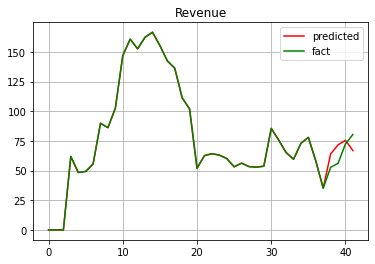

In [38]:
fig, ax = plt.subplots()

ax.plot(revenue_with_predictions[:-4] + list(revenue_forecast), label = 'predicted', color='red')
ax.plot(revenue_with_predictions[:-4] + test['AMPY'][0], label = 'fact', color='green')

ax.legend()
ax.grid()
plt.title('Revenue')
plt.show()

In [40]:
print(f'mean squared error revenue: {mean_squared_error(x[0], revenue_forecast)}')

mean squared error revenue: 140.56633591666667


In [ ]:
_, income_forecast, _ = run_ts_forecasting_example(dataset=train['AMPY'][1], horizon=4, timeout=2., visualization=False)

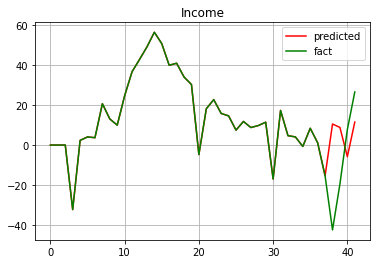

In [41]:
fig, ax = plt.subplots()

ax.plot(income_with_predictions[:-4] + list(income_forecast), label = 'predicted', color='red')
ax.plot(income_with_predictions[:-4] + test['AMPY'][1], label = 'fact', color='green')

ax.legend()
ax.grid()
plt.title('Income')
plt.show()

In [44]:
print(f'mean squared error income: {mean_squared_error(x[1], income_forecast)}')

mean squared error income: 1004.2893248644883


## Conclusions

AutoML framework noticeably improved quality of forecasting, especially in revenue. It became possible thanks to using time series cross-validation and models, that are more adapted to time series forecasting than Fradient Boosting. Both models are better of predicting revenue than income, most likely bacause it is less volatile.